
# Predicting wildfire occurrence in Alaska

### Hana Matsumoto

---

## Import libraries

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rasterio
import shapely

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Wildfire dataset

### Import and inspect data

In [3]:
# Import dataset
#WF_df = pd.read_csv('data/Wildland_Fire_Incident_Locations.csv')
WF_df = gpd.read_file('data/Incidents.shp')
# Display
WF_df.head()

,OBJECTID,SourceOID,ABCDMisc,ADSPermiss,Containmen,ControlDat,CreatedByS,IncidentSi,DiscoveryA,DispatchCe,...,Organizati,StrategicD,CreatedOnD,ModifiedOn,IsCpxChild,CpxName,CpxID,SourceGlob,GlobalID,geometry
0,57,1398497,NaN,DEFAULT,NaN,NaN,firebeans,0.1,0.0,AKYTDC,...,NaN,NaN,2016-06-25,2016-08-08,0,NaN,NaN,{A22F62A6-32FD-4690-B843-D1F7B76D5BB6},{C2E620F8-6951-42C3-8AA9-AB1334F2F1D8},POINT (-144.25003 67.61667)
1,147,1403604,NaN,DEFAULT,NaN,NaN,firebeans,0.1,0.0,AKYTDC,...,NaN,NaN,2016-06-27,2016-07-22,0,NaN,NaN,{6A2AC1E4-64E5-4E8F-9769-6E5981CE387C},{124CC6EF-6D92-4E8A-905F-0134588D0638},POINT (-149.40003 67.46667)
2,486,23828864,NaN,DEFAULT,NaN,NaN,wildcad,18.0,1.0,AKCGFC,...,NaN,NaN,2022-04-12,2022-05-06,0,NaN,NaN,{FEF701E4-8657-41E0-BF21-0B4C6A58D5B9},{DC04511E-03BA-44F1-976D-F634DF08A48D},POINT (-149.72942 60.48031)
3,786,1400174,NaN,DEFAULT,NaN,NaN,firebeans,0.1,0.0,AKYTDC,...,NaN,NaN,2016-06-26,2016-08-08,0,NaN,NaN,{56B9C519-12CC-45C6-B9BC-51140189185D},{5CFF103B-E3D4-43DA-B2A7-576E60ECD509},POINT (-146.53336 63.76667)
4,1278,22050793,NaN,DEFAULT,NaN,NaN,wildcad,22.0,1.0,AKCGFC,...,NaN,NaN,2021-10-19,2021-10-29,0,NaN,NaN,{FF2E4A79-055D-44A2-9B3B-B197C8ABC755},{FA9F8F49-3EEF-4201-B2AE-5EC6C411B1DA},POINT (-149.56752 60.56769)


In [4]:
# Checking out dataset
WF_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 95 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    4624 non-null   int64   
 1   SourceOID   4624 non-null   int64   
 2   ABCDMisc    5 non-null      object  
 3   ADSPermiss  4624 non-null   object  
 4   Containmen  4335 non-null   object  
 5   ControlDat  4306 non-null   object  
 6   CreatedByS  4624 non-null   object  
 7   IncidentSi  4558 non-null   float64 
 8   DiscoveryA  4500 non-null   float64 
 9   DispatchCe  4531 non-null   object  
 10  EstimatedC  1508 non-null   float64 
 11  FinalAcres  2867 non-null   float64 
 12  FinalFireR  0 non-null      float64 
 13  FinalFir_1  0 non-null      float64 
 14  FinalFir_2  738 non-null    object  
 15  FireBehavi  2810 non-null   object  
 16  FireBeha_1  438 non-null    object  
 17  FireBeha_2  421 non-null    object  
 18  FireBeha_3  252 non-null    object  
 19

In [5]:
# Statistics of numeric columns
WF_df.describe()

,OBJECTID,SourceOID,IncidentSi,DiscoveryA,EstimatedC,FinalAcres,FinalFireR,FinalFir_1,FireDepart,FireStrate,...,IsReimburs,IsTrespass,IsUnifiedC,PercentCon,PercentPer,POOJuris_2,POOLegal_4,TotalIncid,EstimatedF,IsCpxChild
count,4624.000000,4.624000e+03,4558.000000,4500.000000,1.508000e+03,2867.000000,0.0,0.0,0.0,488.000000,...,4600.000000,1813.000000,357.0,973.000000,577.000000,0.0,396.000000,559.000000,1.980000e+02,4624.000000
mean,184037.604455,7.701372e+06,3740.540667,36.096378,3.391441e+05,1503.977168,NaN,NaN,NaN,1.508197,...,0.297609,0.014341,0.0,37.671120,34.913345,NaN,18.234848,14.121646,2.251111e+06,0.015138
std,62613.516597,8.340110e+06,25040.335697,353.222213,1.896804e+06,11592.905652,NaN,NaN,NaN,11.114484,...,0.457256,0.118924,0.0,47.306186,47.284446,NaN,10.384648,21.203728,6.667362e+06,0.122117
min,57.000000,5.009160e+05,0.000000,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,NaN,1.000000,0.000000,0.000000e+00,0.000000
25%,132879.250000,1.134369e+06,0.100000,0.100000,0.000000e+00,0.100000,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,NaN,9.000000,0.000000,5.000000e+04,0.000000
50%,185308.500000,4.442968e+06,0.400000,0.100000,1.102500e+03,0.100000,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,NaN,18.000000,7.000000,2.500000e+05,0.000000
75%,236837.750000,9.642080e+06,49.925000,1.000000,4.057103e+04,2.000000,NaN,NaN,NaN,0.000000,...,1.000000,0.000000,0.0,100.000000,100.000000,NaN,27.000000,21.000000,1.000000e+06,0.000000
max,298395.000000,2.387793e+07,865625.000000,15160.000000,4.810109e+07,308922.700000,NaN,NaN,NaN,100.000000,...,1.000000,1.000000,0.0,100.000000,100.000000,NaN,36.000000,188.000000,5.500000e+07,1.000000


In [10]:
#sns.displot(WF_df['IncidentSize'])

### Clean dataset

#### *Removing unwanted columns and fixing missing values*

In [6]:
# Selecting only columns of interest
# Too many columns to use df.drop()
# WF_df_drop = WF_df[['X', 'Y', 'OBJECTID', 'IncidentSize', 'FireBehaviorGeneral', 
#                'FireCause', 'FireDiscoveryDateTime', 'POOCounty', 
#                'POOFips', 'POOLandownerCategory', 'PrimaryFuelModel']]

WF_df_drop = WF_df[['OBJECTID', 'IncidentSi', 'FireBehavi', 
               'FireCause', 'FireDiscov', 'POOCounty', 
               'POOFips', 'POOLandown', 'PrimaryFue', 'geometry']]

In [7]:
# Check for null values
WF_df_drop.isnull().sum()

OBJECTID         0
IncidentSi      66
FireBehavi    1814
FireCause       52
FireDiscov       0
POOCounty        0
POOFips          0
POOLandown     189
PrimaryFue    2018
geometry         0
dtype: int64

In [8]:
# Drop columns with too many nulls values
# Won't be useful for predicting
WF_df_drop = WF_df_drop.drop(['FireBehavi', 'PrimaryFue'], axis=1)
#WF_df_drop = WF_df[['X', 'Y', 'OBJECTID', 'IncidentSize', 
#               'FireCause', 'FireDiscoveryDateTime', 
#               'POOCounty', 'POOFips', 'POOLandownerCategory']]

In [9]:
# Check on missing values
WF_df_drop.isnull().sum()

OBJECTID        0
IncidentSi     66
FireCause      52
FireDiscov      0
POOCounty       0
POOFips         0
POOLandown    189
geometry        0
dtype: int64


#### *Selecting incidents with fire of a certain size*

In this case, I am interested in fires 10 units (presumably acres) and larger


In [10]:
# Locate fires
WF_df_size = WF_df_drop.loc[WF_df_drop['IncidentSi'] >= 10]

In [11]:
# How many fire incidents are left?
WF_df_size.shape

(1447, 8)

In [12]:
# Check for nulls
WF_df_size.isnull().sum()

OBJECTID       0
IncidentSi     0
FireCause      9
FireDiscov     0
POOCounty      0
POOFips        0
POOLandown    93
geometry       0
dtype: int64

In [13]:
# I am choosing to just drop all rows (total of 102, should leave me with 1345 fires) with missing values
WF_df_size = WF_df_size.dropna(axis=0)
WF_df_size.shape

(1345, 8)

In [14]:
# Check on statistics again
WF_df_size.describe()

,OBJECTID,IncidentSi
count,1345.000000,1345.000000
mean,185894.981413,10319.396461
std,60639.265943,29898.097458
min,486.000000,10.000000
25%,135871.000000,65.200000
50%,191801.000000,467.200000
75%,236263.000000,5083.500000
max,291584.000000,312918.200000



#### *Time feature*

Need to convert date column and make seperate year, month, day columns


In [15]:
# Create copy of df
WF_df_time = WF_df_size.copy()

# Converting time
WF_df_time['FireDiscov'] = pd.to_datetime(WF_df_time["FireDiscov"]).dt.date
WF_df_time

,OBJECTID,IncidentSi,FireCause,FireDiscov,POOCounty,POOFips,POOLandown,geometry
2,486,18.0,Undetermined,2022-03-16,Kenai Peninsula,02122,USFS,POINT (-149.72942 60.48031)
4,1278,22.0,Undetermined,2021-10-19,Kenai Peninsula,02122,USFS,POINT (-149.56752 60.56769)
5,2575,212504.4,Undetermined,2022-06-26,Yukon-Koyukuk,02290,State,POINT (-151.16767 64.83240)
8,5090,919.6,Human,2022-05-08,Aleutians West,02016,DOD,POINT (-176.64529 51.95444)
9,5850,40.0,Undetermined,2020-11-18,Kenai Peninsula,02122,USFS,POINT (-149.57622 60.56098)
...,...,...,...,...,...,...,...,...
4603,290626,11305.6,Natural,2018-06-06,Yukon-Koyukuk,02290,BLM,POINT (-151.76470 65.90983)
4609,291108,200.0,Natural,2014-08-12,Nome,02180,Tribal,POINT (-159.88303 64.75000)
4611,291217,1682.0,Natural,2015-06-26,Yukon-Koyukuk,02290,State,POINT (-153.76669 63.56667)
4612,291240,2695.0,Natural,2015-06-22,Yukon-Koyukuk,02290,Tribal,POINT (-155.41203 64.57450)


In [16]:
# Creating year, month, date columns
WF_df_time['year'] = pd.DatetimeIndex(WF_df_time['FireDiscov']).year
WF_df_time['month'] = pd.DatetimeIndex(WF_df_time['FireDiscov']).month
WF_df_time['day'] = pd.DatetimeIndex(WF_df_time['FireDiscov']).day
WF_df_time

,OBJECTID,IncidentSi,FireCause,FireDiscov,POOCounty,POOFips,POOLandown,geometry,year,month,day
2,486,18.0,Undetermined,2022-03-16,Kenai Peninsula,02122,USFS,POINT (-149.72942 60.48031),2022,3,16
4,1278,22.0,Undetermined,2021-10-19,Kenai Peninsula,02122,USFS,POINT (-149.56752 60.56769),2021,10,19
5,2575,212504.4,Undetermined,2022-06-26,Yukon-Koyukuk,02290,State,POINT (-151.16767 64.83240),2022,6,26
8,5090,919.6,Human,2022-05-08,Aleutians West,02016,DOD,POINT (-176.64529 51.95444),2022,5,8
9,5850,40.0,Undetermined,2020-11-18,Kenai Peninsula,02122,USFS,POINT (-149.57622 60.56098),2020,11,18
...,...,...,...,...,...,...,...,...,...,...,...
4603,290626,11305.6,Natural,2018-06-06,Yukon-Koyukuk,02290,BLM,POINT (-151.76470 65.90983),2018,6,6
4609,291108,200.0,Natural,2014-08-12,Nome,02180,Tribal,POINT (-159.88303 64.75000),2014,8,12
4611,291217,1682.0,Natural,2015-06-26,Yukon-Koyukuk,02290,State,POINT (-153.76669 63.56667),2015,6,26
4612,291240,2695.0,Natural,2015-06-22,Yukon-Koyukuk,02290,Tribal,POINT (-155.41203 64.57450),2015,6,22


In [17]:
# Drop FireDiscoveryDateTime
WF_df_time = WF_df_time.drop(['FireDiscov'], axis=1)
WF_df_time

,OBJECTID,IncidentSi,FireCause,POOCounty,POOFips,POOLandown,geometry,year,month,day
2,486,18.0,Undetermined,Kenai Peninsula,02122,USFS,POINT (-149.72942 60.48031),2022,3,16
4,1278,22.0,Undetermined,Kenai Peninsula,02122,USFS,POINT (-149.56752 60.56769),2021,10,19
5,2575,212504.4,Undetermined,Yukon-Koyukuk,02290,State,POINT (-151.16767 64.83240),2022,6,26
8,5090,919.6,Human,Aleutians West,02016,DOD,POINT (-176.64529 51.95444),2022,5,8
9,5850,40.0,Undetermined,Kenai Peninsula,02122,USFS,POINT (-149.57622 60.56098),2020,11,18
...,...,...,...,...,...,...,...,...,...,...
4603,290626,11305.6,Natural,Yukon-Koyukuk,02290,BLM,POINT (-151.76470 65.90983),2018,6,6
4609,291108,200.0,Natural,Nome,02180,Tribal,POINT (-159.88303 64.75000),2014,8,12
4611,291217,1682.0,Natural,Yukon-Koyukuk,02290,State,POINT (-153.76669 63.56667),2015,6,26
4612,291240,2695.0,Natural,Yukon-Koyukuk,02290,Tribal,POINT (-155.41203 64.57450),2015,6,22



#### *Checking out unique values*


In [18]:
WF_df_time['FireCause'].unique()

array(['Undetermined', 'Human', 'Unknown', 'Natural'], dtype=object)

In [19]:
(WF_df_time['FireCause'] == 'Undetermined').sum()

32

In [20]:
(WF_df_time['FireCause'] == 'Unknown').sum()

13

In [21]:
WF_df_time['POOLandown'].unique()

array(['USFS', 'State', 'DOD', 'Private', 'ANCSA', 'USFWS', 'NPS', 'BLM',
       'Tribal', 'County', 'BIA', 'DOE'], dtype=object)

#### *Exploring data*

In [24]:
# Checking correlation
# Compute correlation matrix
corr_matrix = WF_df_time.corr()

# Display just house value correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\2504619115.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = WF_df_time.corr()


IncidentSi    1.000000
day           0.068864
year          0.026757
OBJECTID     -0.026862
month        -0.062542
Name: IncidentSi, dtype: float64

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\2503335017.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(WF_df_time.corr(),annot=True,cmap='viridis',linewidths=.5)


<Axes: >

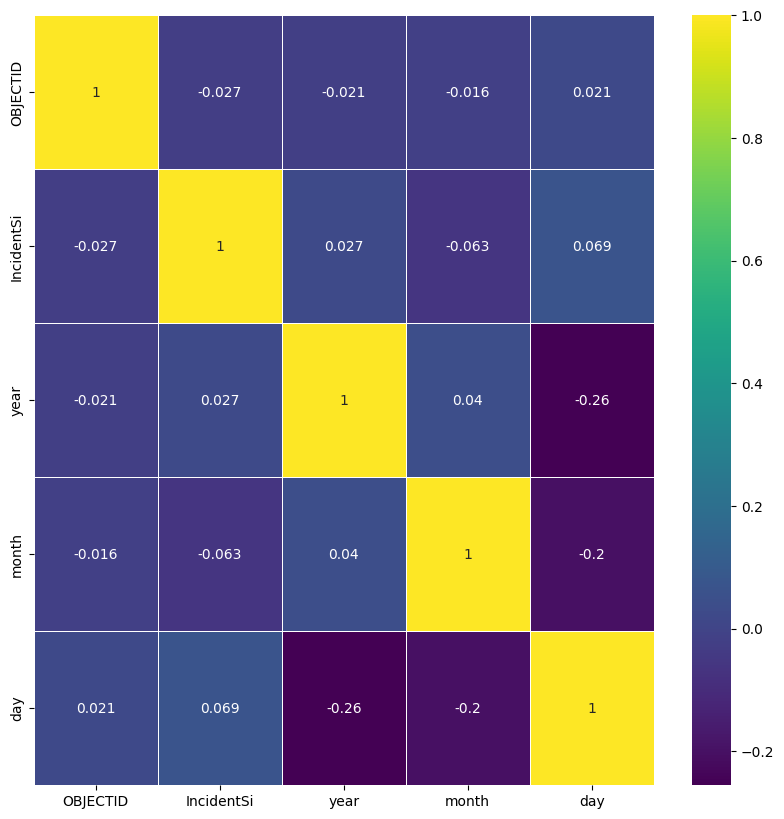

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(WF_df_time.corr(),annot=True,cmap='viridis',linewidths=.5)

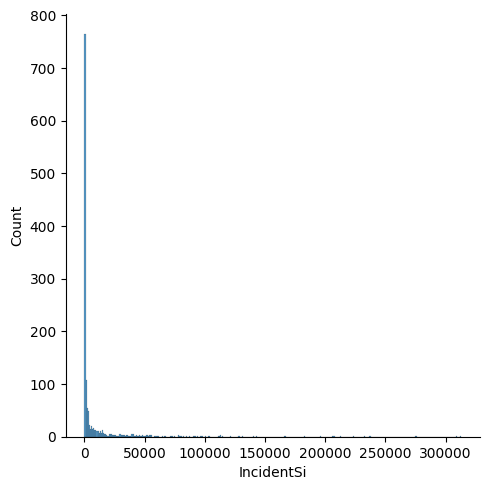

In [25]:
sns.displot(WF_df_time['IncidentSi'])

#### *Time to convert categorical features*

In [34]:
WF_df_time

,OBJECTID,IncidentSi,FireCause,POOCounty,POOFips,POOLandown,geometry,year,month,day
2,486,18.0,Undetermined,Kenai Peninsula,02122,USFS,POINT (-149.72942 60.48031),2022,3,16
4,1278,22.0,Undetermined,Kenai Peninsula,02122,USFS,POINT (-149.56752 60.56769),2021,10,19
5,2575,212504.4,Undetermined,Yukon-Koyukuk,02290,State,POINT (-151.16767 64.83240),2022,6,26
8,5090,919.6,Human,Aleutians West,02016,DOD,POINT (-176.64529 51.95444),2022,5,8
9,5850,40.0,Undetermined,Kenai Peninsula,02122,USFS,POINT (-149.57622 60.56098),2020,11,18
...,...,...,...,...,...,...,...,...,...,...
4603,290626,11305.6,Natural,Yukon-Koyukuk,02290,BLM,POINT (-151.76470 65.90983),2018,6,6
4609,291108,200.0,Natural,Nome,02180,Tribal,POINT (-159.88303 64.75000),2014,8,12
4611,291217,1682.0,Natural,Yukon-Koyukuk,02290,State,POINT (-153.76669 63.56667),2015,6,26
4612,291240,2695.0,Natural,Yukon-Koyukuk,02290,Tribal,POINT (-155.41203 64.57450),2015,6,22


In [35]:
# cat_columns = WF_df[['FireBehaviorGeneral', 'FireCause', 'FireCauseGeneral', 
#                'POOCounty', 'POOLandownerCategory', 'PrimaryFuelModel']]
# pd.get_dummies(cat_columns, prefix=None, dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

# Copy the original data
features = WF_df_time.copy()

# Select the numeric columns
# numeric_subset = WF_df_time.select_dtypes('number')
numeric_subset = WF_df_time[['OBJECTID', 'IncidentSi', 'POOFips', 
                             'geometry', 'year', 'month', 'day']]

# Create columns with log of numeric columns
# for col in numeric_subset.columns:
#     # Skip the Energy Star Score column
#     if col == 'IncidentSize':
#         next
#     else:
#         numeric_subset['log_' + col] = np.log(numeric_subset[col])
#numeric_subset = WF_df_time[['FireCause', 'POOCounty', 'POOLandownerCategory']]
        
# Select the categorical columns
categorical_subset = WF_df_time[['FireCause', 'POOCounty', 'POOLandown']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

(1345, 44)

#### *Exploring data*

In [36]:
# Checking correlation
# Compute correlation matrix
corr_matrix = features.corr()

# Display just fire size correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\2988248094.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = features.corr()


IncidentSi                        1.000000
POOCounty_Yukon-Koyukuk           0.165045
FireCause_Undetermined            0.109592
POOLandown_USFWS                  0.089276
POOLandown_Tribal                 0.074582
day                               0.068864
FireCause_Natural                 0.051951
POOCounty_Dillingham              0.029820
POOLandown_BLM                    0.027444
POOCounty_Kusilvak                0.027088
year                              0.026757
POOCounty_Kenai Peninsula         0.013588
POOLandown_State                  0.009276
POOLandown_DOE                   -0.008523
POOCounty_Bristol Bay            -0.011420
POOLandown_BIA                   -0.012516
POOCounty_Aleutians West         -0.012666
POOCounty_Aleutians East         -0.013267
POOCounty_Juneau                 -0.013278
POOCounty_Kodiak Island          -0.013678
FireCause_Unknown                -0.018214
POOCounty_Wade Hampton           -0.022476
POOCounty_Lake and Peninsula     -0.023374
POOCounty_B

In [ ]:
#plt.figure(figsize=(10, 10))
#sns.heatmap(features.corr(),annot=True,cmap='viridis',linewidths=.5)

## Forest type dataset

### Importing and reprojecting

In [110]:
from rasterio.crs import CRS
import rioxarray as rxr
# Import master raster file
#src = rxr.open_rasterio('data/alaska_foresttype_63360.img')
#src
src = rxr.open_rasterio('data/AK_foresttype.tif', masked=True).squeeze()

In [47]:
# Find crs of raster
src.rio.crs

CRS.from_epsg(3338)

In [39]:
# Find crs of fires
features.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [111]:
# Reproject raster into same crs as features
src_wgs84 = src.rio.reproject(features.crs)
src_wgs84.rio.crs

CRS.from_epsg(4326)

### Plotting fires on top of raster to see where fires might sit

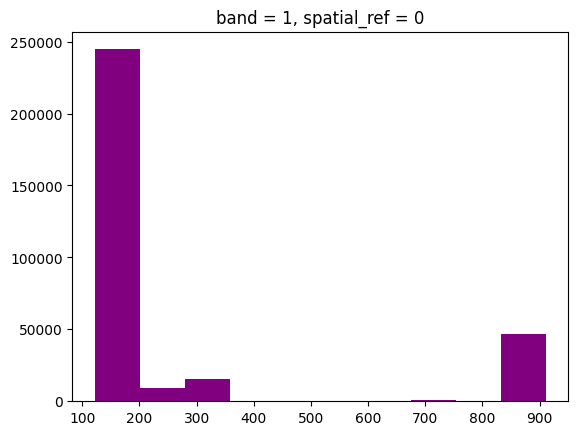

In [112]:
# Checking range of values
src_wgs84.plot.hist(color="purple")
plt.show()

In [131]:
AK = gpd.read_file('data/GU_StateOrTerritory.shp')

In [133]:
AK.to_crs('EPSG:4326')

,permanent_,source_fea,source_dat,source_d_1,source_ori,loaddate,fcode,state_fips,state_name,population,areasqkm,gnis_id,gnis_name,shape_Leng,shape_Area,ObjectID,geometry
0,5d2d8414-3c59-4a70-8386-106c37e2e360,02,02b32600-f8db-4dd6-a9f5-2003d67e4500,"2020 TIGER/Line Shapefile, Current State and E...",U.S. Census Bureau,2021-06-02,61100,02,Alaska,710231,1.724322e+06,1785533,State of Alaska,252.07949,314.105748,1,"MULTIPOLYGON (((-165.25416 60.91711, -165.2630..."


In [127]:
from matplotlib import colors
# Vegetation class values in raster
levels =[122, 125, 270, 271, 281, 
         290, 301, 304, 305, 703, 
         704, 709, 901, 902, 904, 911]
clrs = ['lightgreen','black','green','blue','red', 
        'yellow', 'pink', 'orange', 'wheat', 'purple', 
        'lightseagreen', 'fuchsia', 'brown', 'silver', 'lime'] 

cmap, norm = colors.from_levels_and_colors(levels, clrs)

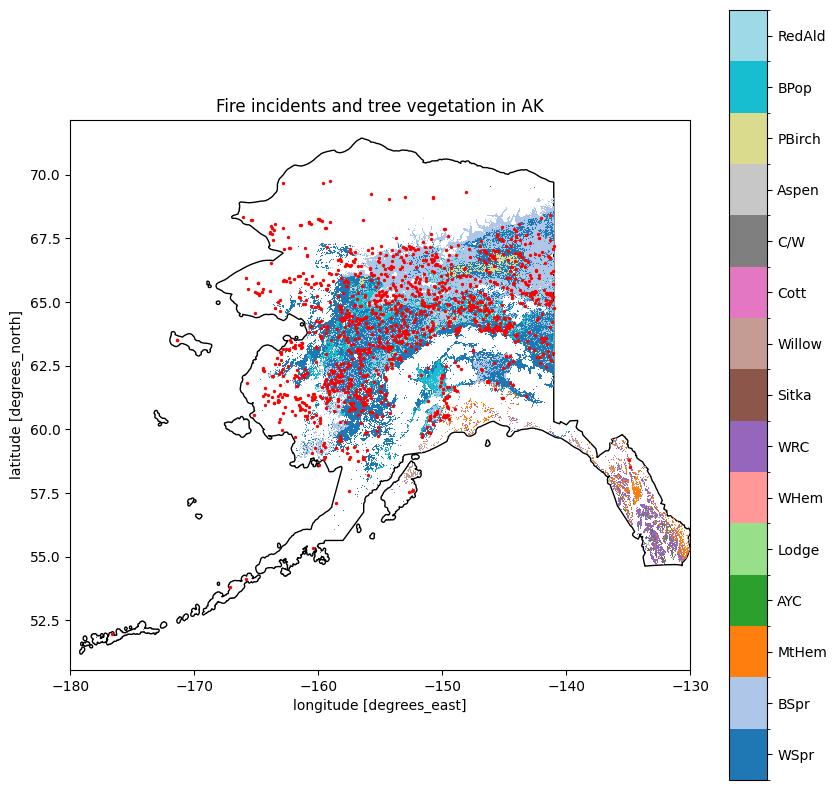

In [146]:
f, ax = plt.subplots(figsize=(10, 10))

AK.plot(ax=ax, color = 'white', edgecolor='black')
#src_wgs84.plot(ax=ax, cmap = 'tab20b')#, add_colorbar=False) ##xarray
veg = src_wgs84.plot(ax=ax, cmap = 'tab20', norm=norm, add_colorbar=False) ##xarray 
cbar = plt.colorbar(veg)

boundary_means = [np.mean([norm.boundaries[ii], norm.boundaries[ii - 1]])
                  for ii in range(1, len(norm.boundaries))]

category_names = ['WSpr', 'BSpr', 'MtHem', 'AYC', 'Lodge',
                 'WHem', 'WRC', 'Sitka', 'Willow', 'Cott', 'C/W', 
                  'Aspen', 'PBirch', 'BPop', 'RedAld']
cbar.set_ticks(boundary_means)
cbar.set_ticklabels(category_names)

# src3.plt.imshow(ax=ax, cmap = 'tab20b')#, add_colorbar=False)
#im = ax.imshow(AK_type, cmap='tab20b') ## rasterio.open
features.plot(ax=ax, color = 'red', markersize =2)
ax.set(title="Fire incidents and tree vegetation in AK")
#ax.set_axis_off()
plt.xlim([-180, -130])
#plt.ylim([0, 100])
plt.show()

Thank yous:

[1](https://stackoverflow.com/questions/67506404/how-to-assign-particular-color-to-each-pixel-in-image), [2](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/)

A lot of the fires & vegetation look to be in interior Alaska

### Checking how much fire and vegetation in interior Alaska

In [144]:
# Import interior Alaska .shp
IAK = gpd.read_file('data/interior_AK.shp')

In [145]:
IAK.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

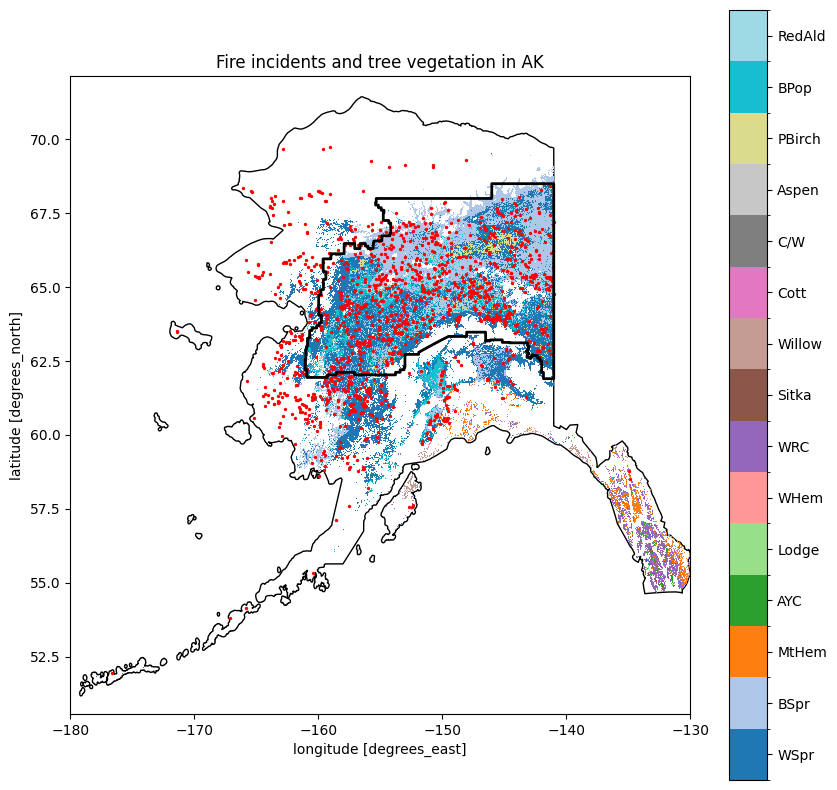

In [150]:
# Looking at interior Alaska
f, ax = plt.subplots(figsize=(10, 10))

AK.plot(ax=ax, color = 'white', edgecolor='black')
#src_wgs84.plot(ax=ax, cmap = 'tab20b')#, add_colorbar=False) ##xarray
veg = src_wgs84.plot(ax=ax, cmap = 'tab20', norm=norm, add_colorbar=False) ##xarray 
cbar = plt.colorbar(veg)

boundary_means = [np.mean([norm.boundaries[ii], norm.boundaries[ii - 1]])
                  for ii in range(1, len(norm.boundaries))]

category_names = ['WSpr', 'BSpr', 'MtHem', 'AYC', 'Lodge',
                 'WHem', 'WRC', 'Sitka', 'Willow', 'Cott', 'C/W', 
                  'Aspen', 'PBirch', 'BPop', 'RedAld']
cbar.set_ticks(boundary_means)
cbar.set_ticklabels(category_names)

features.plot(ax=ax, color = 'red', markersize =2)
IAK.plot(ax=ax, facecolor = 'none', edgecolor='black', lw=2)

ax.set(title="Fire incidents and tree vegetation in AK")
plt.xlim([-180, -130])
#plt.ylim([0, 100])
plt.show()

In [152]:
# Clip fire data to interior Alaska
fire_clip = gpd.clip(features, IAK)
fire_clip

,OBJECTID,IncidentSi,POOFips,geometry,year,month,day,FireCause_Human,FireCause_Natural,FireCause_Undetermined,...,POOLandown_BLM,POOLandown_County,POOLandown_DOD,POOLandown_DOE,POOLandown_NPS,POOLandown_Private,POOLandown_State,POOLandown_Tribal,POOLandown_USFS,POOLandown_USFWS
1394,143148,2738.0,02290,POINT (-156.58969 62.22100),2015,6,22,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1727,158204,173.0,02290,POINT (-156.71641 62.40528),2019,6,8,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4156,268737,13924.0,02290,POINT (-157.64297 62.46817),2017,6,5,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4519,286701,11.0,02290,POINT (-154.57969 62.05683),2015,6,28,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1167,133521,1427.1,02290,POINT (-154.48197 62.37735),2018,6,5,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,169412,202.8,02290,POINT (-152.67136 67.19581),2016,6,27,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4505,286036,177.0,02290,POINT (-151.57933 67.34972),2020,6,6,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1702,156785,60087.7,02290,POINT (-148.69093 67.25764),2022,6,21,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2841,208172,323.3,02290,POINT (-149.49403 67.61670),2015,7,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Of the 1345 fires, 863 occur in interior Alaska. That's over 50% of the fires.

### Checking what vegetation occurs in interior Alaska

In [154]:
from shapely.geometry import mapping
# Clip vegetation data to interior Alaska
veg_clip = src_wgs84.rio.clip(IAK.geometry.apply(mapping))

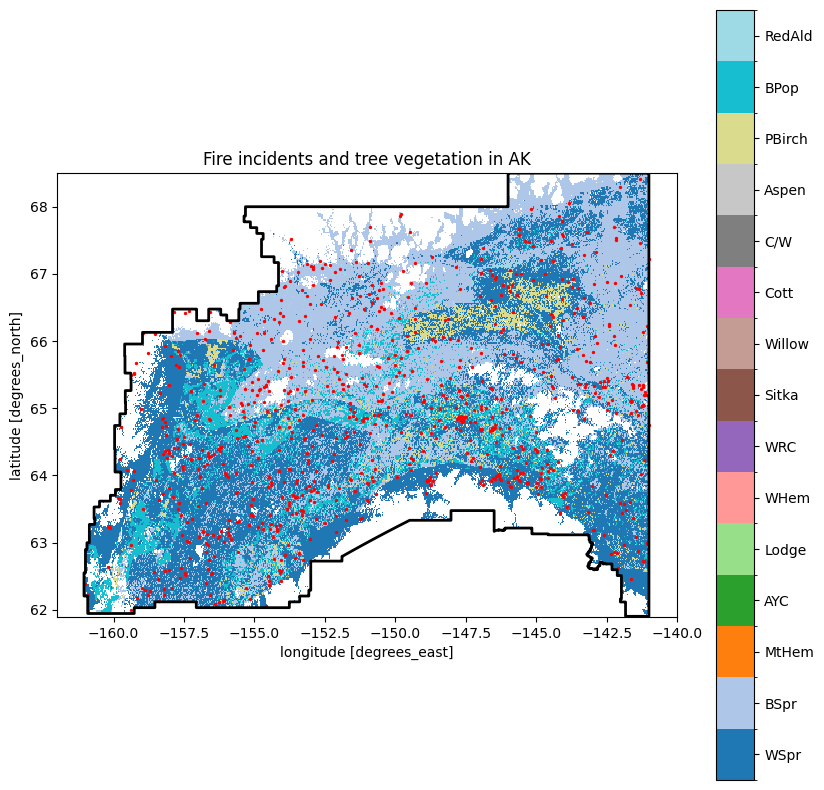

In [159]:
# Looking at everything one more time
f, ax = plt.subplots(figsize=(10, 10))

veg = veg_clip.plot(ax=ax, cmap = 'tab20', norm=norm, add_colorbar=False) ##xarray 
cbar = plt.colorbar(veg)

boundary_means = [np.mean([norm.boundaries[ii], norm.boundaries[ii - 1]])
                  for ii in range(1, len(norm.boundaries))]

category_names = ['WSpr', 'BSpr', 'MtHem', 'AYC', 'Lodge',
                 'WHem', 'WRC', 'Sitka', 'Willow', 'Cott', 'C/W', 
                  'Aspen', 'PBirch', 'BPop', 'RedAld']
cbar.set_ticks(boundary_means)
cbar.set_ticklabels(category_names)

fire_clip.plot(ax=ax, color = 'red', markersize =2)
IAK.plot(ax=ax, facecolor = 'none', edgecolor='black', lw=2)

ax.set(title="Fire incidents and tree vegetation in AK")
plt.xlim([-162, -140])
#plt.ylim([0, 100])
plt.show()

What vegetation (values) is in this dataset now?

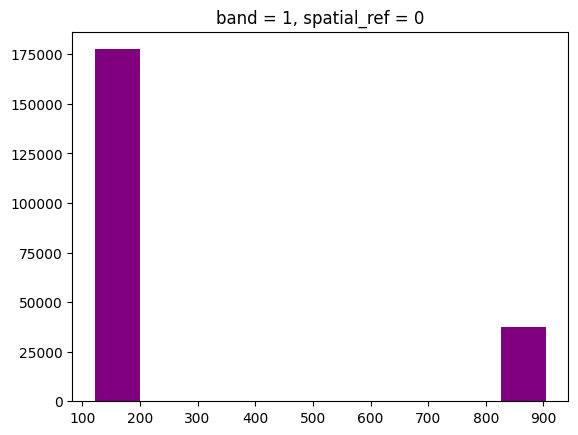

In [175]:
# Check raster values
veg_clip.plot.hist(color="purple")
plt.show()

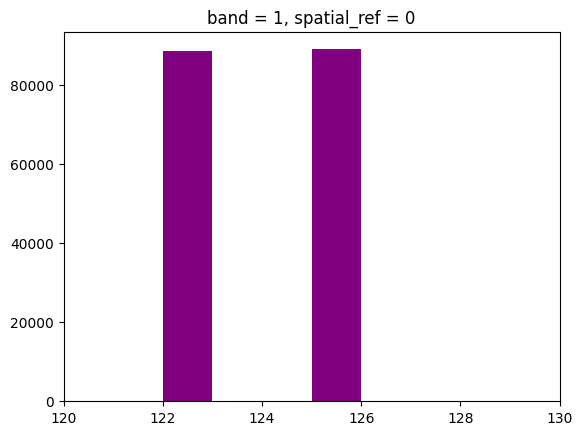

In [174]:
veg_clip.plot.hist(color="purple",
                  bins=[122, 123, 125, 126])
plt.xlim([120, 130])
plt.show()

122 = white spruce, 125 = black spruce

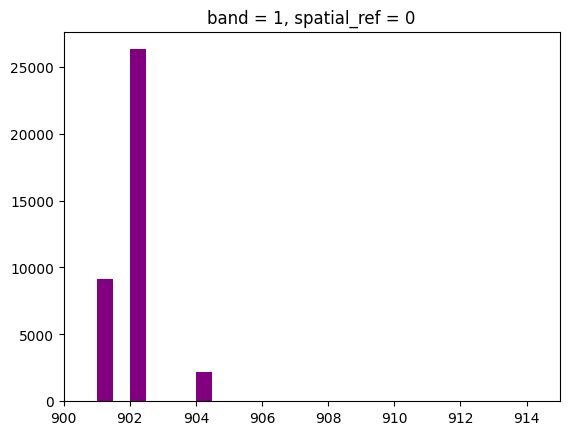

In [183]:
veg_clip.plot.hist(color="purple",
                  bins=[901, 901.5, 902, 902.5, 903, 903.5, 904, 904.5, 905, 910, 911, 912])
plt.xlim([900, 915])
plt.show()

901 = Aspen, 902 = Paper Birch, 904 = Balsam Poplar


### Feature engineer with vegetation

Pulled cells out of raster with the values above and created shapefiles in ArcGIS Pro.

Decided on these values because they seem to support more fire than the other vegetation types.

In [ ]:
122, 125, 270, 271, 281, 
         290, 301, 304, 305, 703, 
         704, 709, 901, 902, 904, 911

In [228]:
# Read datasets
blackspruce = gpd.read_file('data/blackspruce.shp')
paperbirch = gpd.read_file('data/paperbirch.shp')
whitespruce = gpd.read_file('data/whitespruceshp.shp')
aspen = gpd.read_file('data/aspen.shp')
poplar = gpd.read_file('data/bpop.shp')

In [229]:
# Check crs
aspen.crs

<Derived Projected CRS: PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["Nor ...>
Name: NAD_1983_Albers
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [231]:
# Reproject everything to NAD83 / Alaska Albers (EPSG:3338)
blackspruce_utm = blackspruce.to_crs('EPSG:3338')
paperbirch_utm = paperbirch.to_crs('EPSG:3338')
whitespruce_utm = whitespruce.to_crs('EPSG:3338')
aspen_utm = aspen.to_crs('EPSG:3338')
poplar_utm = poplar.to_crs('EPSG:3338')

WF_gdf = features.to_crs('EPSG:3338')

In [ ]:
# Merge vegetation gdfs together to use
#north_south_carolina = gpd.pd.concat([north_carolina, south_carolina])

In [233]:
# Compute distance to black spruce
distance_to_blackspruce = []
for i in range(WF_gdf.shape[0]):
    distance_to_blackspruce.append(blackspruce_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_blackspruce'] = distance_to_blackspruce

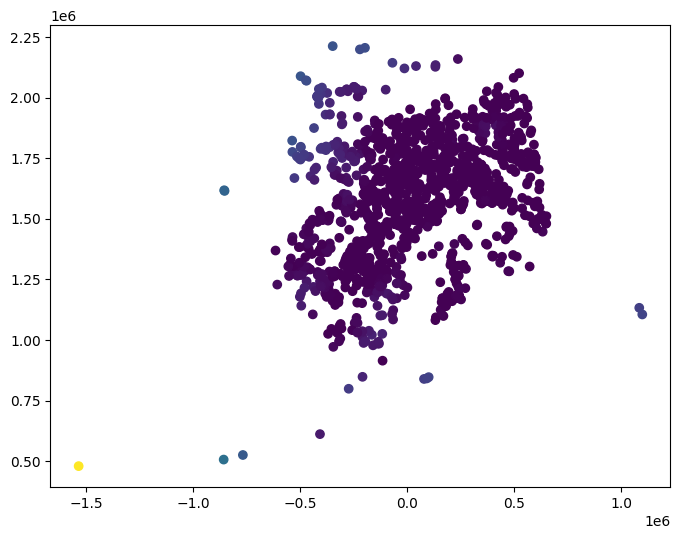

In [234]:
# Quickly check that it worked!
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(WF_gdf['geometry'].x, WF_gdf['geometry'].y, c=WF_gdf['distance_to_blackspruce'])

In [235]:
# Compute distance to paper birch
distance_to_paperbirch = []
for i in range(WF_gdf.shape[0]):
    distance_to_paperbirch.append(paperbirch_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_paperbirch'] = distance_to_paperbirch

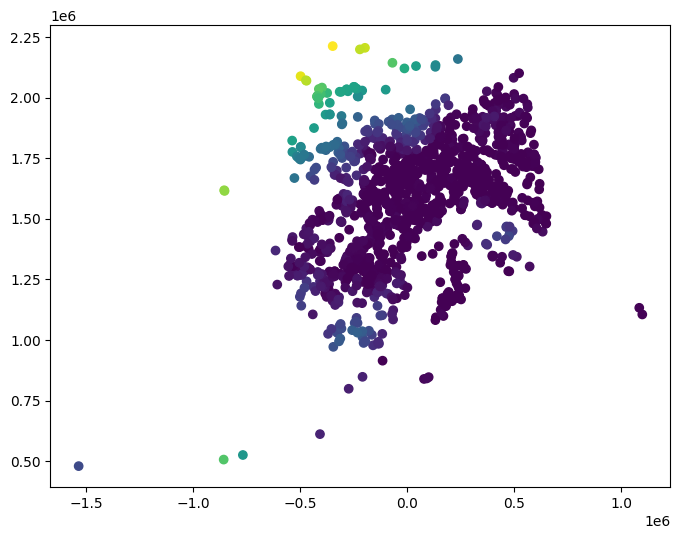

In [236]:
# Quickly check that it worked!
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(WF_gdf['geometry'].x, WF_gdf['geometry'].y, c=WF_gdf['distance_to_paperbirch'])

In [237]:
# Compute distance to white spruce
distance_to_whitespruce = []
for i in range(WF_gdf.shape[0]):
    distance_to_whitespruce.append(whitespruce_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_whitespruce'] = distance_to_whitespruce

In [238]:
# Compute distance to aspen
distance_to_aspen = []
for i in range(WF_gdf.shape[0]):
    distance_to_aspen.append(aspen_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_aspen'] = distance_to_aspen

In [239]:
# Compute distance to aspen
distance_to_poplar = []
for i in range(WF_gdf.shape[0]):
    distance_to_poplar.append(poplar_utm.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_poplar'] = distance_to_poplar

In [240]:
# Compute correlation matrix
corr_matrix = WF_gdf.corr()

# Display just fire size correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\2242348806.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = WF_gdf.corr()


IncidentSi                        1.000000
POOCounty_Yukon-Koyukuk           0.165045
FireCause_Undetermined            0.109592
POOLandown_USFWS                  0.089276
POOLandown_Tribal                 0.074582
day                               0.068864
FireCause_Natural                 0.051951
POOCounty_Dillingham              0.029820
POOLandown_BLM                    0.027444
POOCounty_Kusilvak                0.027088
year                              0.026757
POOCounty_Kenai Peninsula         0.013588
POOLandown_State                  0.009276
POOLandown_DOE                   -0.008523
POOCounty_Bristol Bay            -0.011420
POOLandown_BIA                   -0.012516
POOCounty_Aleutians West         -0.012666
POOCounty_Aleutians East         -0.013267
POOCounty_Juneau                 -0.013278
POOCounty_Kodiak Island          -0.013678
FireCause_Unknown                -0.018214
POOCounty_Wade Hampton           -0.022476
POOCounty_Lake and Peninsula     -0.023374
POOCounty_B

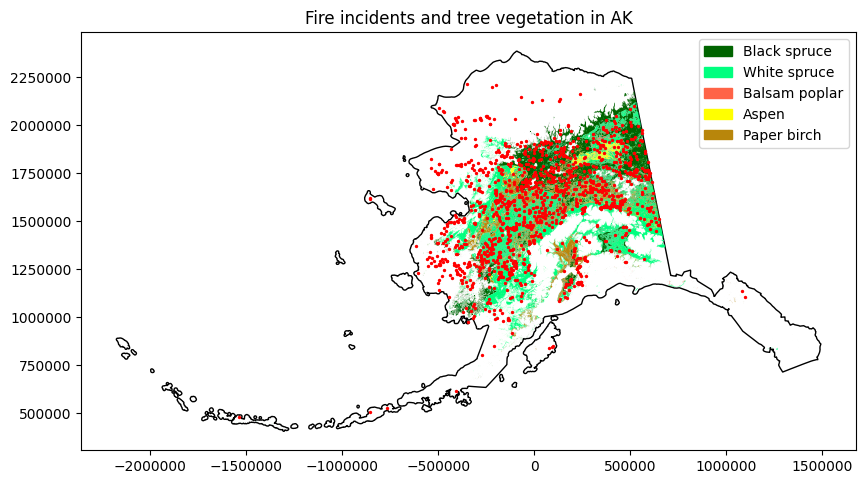

In [353]:
AK_83 = AK.to_crs('EPSG:3338')
import matplotlib.patches as mpatches

# Mapping vegetation and fire incidents
f, ax = plt.subplots(figsize=(10, 10))

AK_83.plot(ax=ax, color = 'white', edgecolor='black')

blackspruce_utm.plot(ax=ax, color = 'darkgreen')
whitespruce_utm.plot(ax=ax, color = 'springgreen')
poplar_utm.plot(ax=ax, color = 'tomato')
aspen_utm.plot(ax=ax, color = 'yellow')
paperbirch_utm.plot(ax=ax, color = 'darkgoldenrod')

WF_gdf.plot(ax=ax, color = 'red', markersize =2)
#IAK.plot(ax=ax, facecolor = 'none', edgecolor='black', lw=2)

ax.set(title="Fire incidents and tree vegetation in AK")
plt.ticklabel_format(style='plain')
grey  = mpatches.Patch(color = 'darkgreen', label = 'Black spruce')
Lblue = mpatches.Patch(color = 'springgreen', label = 'White spruce')
Black = mpatches.Patch(color= 'tomato', label = 'Balsam poplar')
tur  = mpatches.Patch(color = 'yellow', label = 'Aspen')
blue = mpatches.Patch(color = 'darkgoldenrod', label = 'Paper birch')
plt.legend(handles = [grey,Lblue,Black, tur, blue])

plt.show()

In [247]:
# Save WF_gdf so I don't need to run distance cells again
WF_gdf.to_file('data/forest_type_fire')

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\542130121.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  WF_gdf.to_file('data/forest_type_fire')


In [289]:
WF_gdf.describe()

,OBJECTID,IncidentSi,year,month,day,FireCause_Human,FireCause_Natural,FireCause_Undetermined,FireCause_Unknown,POOCounty_Aleutians East,...,POOLandown_Private,POOLandown_State,POOLandown_Tribal,POOLandown_USFS,POOLandown_USFWS,distance_to_blackspruce,distance_to_paperbirch,distance_to_whitespruce,distance_to_aspen,distance_to_poplar
count,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,...,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1.345000e+03,1345.000000,1345.000000,1.345000e+03,1.345000e+03
mean,185894.981413,10319.396461,2017.883271,6.234944,15.466171,0.113011,0.853532,0.023792,0.009665,0.001487,...,0.012639,0.348699,0.027509,0.010409,0.178439,1.643680e+04,27791.645090,6839.797473,4.912809e+04,4.252487e+04
std,60639.265943,29898.097458,2.585829,0.922502,8.217229,0.316724,0.353707,0.152457,0.097873,0.038547,...,0.111754,0.476736,0.163623,0.101530,0.383024,5.156018e+04,63020.522043,23919.164157,9.225590e+04,7.422819e+04
min,486.000000,10.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,135871.000000,65.200000,2015.000000,6.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,487.862795,0.000000,1.758612e+03,4.307512e+03
50%,191801.000000,467.200000,2018.000000,6.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000925e+02,2696.388274,235.266013,1.144428e+04,1.832884e+04
75%,236263.000000,5083.500000,2020.000000,7.000000,22.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,5.941494e+03,20429.738413,2456.676362,5.418798e+04,4.419701e+04
max,291584.000000,312918.200000,2022.000000,11.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.059562e+06,457647.773345,312866.191835,1.406406e+06,1.214642e+06


In [317]:
veg_shp = gpd.pd.concat([blackspruce_utm, whitespruce_utm, poplar_utm, aspen_utm, paperbirch_utm])

In [318]:
testing = WF_gdf.copy()

## Permafrost data

In [246]:
# Read dataset
permafrost = gpd.read_file('data/AK_permafrost.shp')

In [249]:
permafrost.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [250]:
# Reproject to NAD83 / Alaska Albers (EPSG:3338)
permafrost_utm = permafrost.to_crs('EPSG:3338')

In [251]:
permafrost_utm

,PERMAFROST,ACRES,HA,PFROST_2,geometry
0,21,436.18,176.52,Lowland and Upland Area underlain by thick per...,"POLYGON ((-156.46482 71.40968, -156.52155 71.3..."
1,21,108.10,43.75,Lowland and Upland Area underlain by thick per...,"POLYGON ((-156.46482 71.40968, -156.46011 71.4..."
2,21,31225820.51,12636641.25,Lowland and Upland Area underlain by thick per...,"POLYGON ((-156.63056 71.36657, -156.57207 71.3..."
3,21,134.52,54.44,Lowland and Upland Area underlain by thick per...,"POLYGON ((-155.68659 71.27256, -155.65526 71.2..."
4,21,537.29,217.43,Lowland and Upland Area underlain by thick per...,"POLYGON ((-155.54919 71.26037, -155.45319 71.2..."
...,...,...,...,...,...
808,31,49.88,20.19,Not defined,"POLYGON ((-168.41767 52.98705, -168.42739 52.9..."
809,31,144.21,58.36,Not defined,"POLYGON ((-168.48676 52.97032, -168.50257 52.9..."
810,31,1663.81,673.32,Not defined,"POLYGON ((-171.14383 52.55239, -171.19689 52.5..."
811,31,11044.77,4469.66,Not defined,"POLYGON ((-171.25378 52.43950, -171.30748 52.4..."


In [252]:
# Check out permafrost features
permafrost_utm['PFROST_2'].unique()

array(['Lowland and Upland Area underlain by thick permafrost',
       'Mountainous Area underlain by continuous permafrost',
       'Lowland and Upland Area underlain by discontinuous permafrost',
       'Lowland and Upland Area underlain by moderately thick to thin permafrost',
       'Mountainous Area underlain by discontinuous permafrost',
       'Lowland and Upland Area underlain by numerous isolated masses of permafrost',
       'Lowland and Upland Area generally free of permafrost',
       'Not defined',
       'Lowland and Upland Area underlain by isolated masses of permafrost',
       'Mountainous Area underlain by isolated masses of permafrost'],
      dtype=object)

In [261]:
(permafrost_utm['PFROST_2'] == 'Not defined').sum()

544

In [253]:
# Converting catergorical data to numeric
# Copy the original data
perm_features = permafrost_utm.copy()

# Select the numeric columns
numeric_subset2 = permafrost_utm[['PERMAFROST', 'ACRES', 'HA', 'geometry']]
        
# Select the categorical columns
categorical_subset2 = permafrost_utm[['PFROST_2']]

# One hot encode
categorical_subset2 = pd.get_dummies(categorical_subset2)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
perm_features = pd.concat([numeric_subset2, categorical_subset2], axis = 1)

perm_features

,PERMAFROST,ACRES,HA,geometry,PFROST_2_Lowland and Upland Area generally free of permafrost,PFROST_2_Lowland and Upland Area underlain by discontinuous permafrost,PFROST_2_Lowland and Upland Area underlain by isolated masses of permafrost,PFROST_2_Lowland and Upland Area underlain by moderately thick to thin permafrost,PFROST_2_Lowland and Upland Area underlain by numerous isolated masses of permafrost,PFROST_2_Lowland and Upland Area underlain by thick permafrost,PFROST_2_Mountainous Area underlain by continuous permafrost,PFROST_2_Mountainous Area underlain by discontinuous permafrost,PFROST_2_Mountainous Area underlain by isolated masses of permafrost,PFROST_2_Not defined
0,21,436.18,176.52,"POLYGON ((-89989.644 2380505.843, -92123.472 2...",0,0,0,0,0,1,0,0,0,0
1,21,108.10,43.75,"POLYGON ((-89989.644 2380505.843, -89812.636 2...",0,0,0,0,0,1,0,0,0,0
2,21,31225820.51,12636641.25,"POLYGON ((-96223.199 2376052.006, -94120.182 2...",0,0,0,0,0,1,0,0,0,0
3,21,134.52,54.44,"POLYGON ((-61963.163 2364701.935, -60828.416 2...",0,0,0,0,0,1,0,0,0,0
4,21,537.29,217.43,"POLYGON ((-56947.173 2363252.490, -53478.154 2...",0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,31,49.88,20.19,"POLYGON ((-963604.665 435401.281, -964215.643 ...",0,0,0,0,0,0,0,0,0,1
809,31,144.21,58.36,"POLYGON ((-968550.755 434594.198, -969511.845 ...",0,0,0,0,0,0,0,0,0,1
810,31,1663.81,673.32,"POLYGON ((-1154380.153 432018.984, -1157875.03...",0,0,0,0,0,0,0,0,0,1
811,31,11044.77,4469.66,"POLYGON ((-1164831.383 421843.185, -1167987.01...",0,0,0,0,0,0,0,0,0,1


In [263]:
perm_features.columns

Index(['PERMAFROST', 'ACRES', 'HA', 'geometry',
       'PFROST_2_Lowland and Upland Area generally free of permafrost',
       'PFROST_2_Lowland and Upland Area underlain by discontinuous permafrost',
       'PFROST_2_Lowland and Upland Area underlain by isolated masses of permafrost',
       'PFROST_2_Lowland and Upland Area underlain by moderately thick to thin permafrost',
       'PFROST_2_Lowland and Upland Area underlain by numerous isolated masses of permafrost',
       'PFROST_2_Lowland and Upland Area underlain by thick permafrost',
       'PFROST_2_Mountainous Area underlain by continuous permafrost',
       'PFROST_2_Mountainous Area underlain by discontinuous permafrost',
       'PFROST_2_Mountainous Area underlain by isolated masses of permafrost',
       'PFROST_2_Not defined'],
      dtype='object')

In [264]:
free = perm_features.loc[perm_features['PFROST_2_Lowland and Upland Area generally free of permafrost'] == 1 ]

In [272]:
discon = perm_features.loc[(perm_features['PFROST_2_Lowland and Upland Area underlain by discontinuous permafrost'] == 1) | 
                           (perm_features['PFROST_2_Mountainous Area underlain by discontinuous permafrost'] == 1)]

In [275]:
iso = perm_features.loc[(perm_features['PFROST_2_Lowland and Upland Area underlain by isolated masses of permafrost'] == 1) | 
                        (perm_features['PFROST_2_Lowland and Upland Area underlain by numerous isolated masses of permafrost'] == 1) |
                        (perm_features['PFROST_2_Mountainous Area underlain by isolated masses of permafrost'] == 1)]

In [276]:
thick_thin = perm_features.loc[(perm_features['PFROST_2_Lowland and Upland Area underlain by moderately thick to thin permafrost'] == 1)]

In [277]:
thick = perm_features.loc[(perm_features['PFROST_2_Lowland and Upland Area underlain by thick permafrost'] == 1)]

In [278]:
con = perm_features.loc[(perm_features['PFROST_2_Mountainous Area underlain by continuous permafrost'] == 1)]

In [279]:
ND = perm_features.loc[perm_features['PFROST_2_Not defined'] == 1]


### Feature engineer with permafrost type


In [321]:
# Compute distance to free
distance_to_free = []
for i in range(WF_gdf.shape[0]):
    distance_to_free.append(free.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_free'] = distance_to_free

In [325]:
# Compute distance to discontinuous
distance_to_discon = []
for i in range(WF_gdf.shape[0]):
    distance_to_discon.append(discon.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_discon'] = distance_to_discon

In [327]:
# Compute distance to isolated
distance_to_iso = []
for i in range(WF_gdf.shape[0]):
    distance_to_iso.append(iso.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_iso'] = distance_to_iso

In [334]:
# Compute distance to thick_thin
distance_to_thick_thin = []
for i in range(WF_gdf.shape[0]):
    distance_to_thick_thin.append(thick_thin.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_thick_thin'] = distance_to_thick_thin thick

In [336]:
# Compute distance to thick
distance_to_thick = []
for i in range(WF_gdf.shape[0]):
    distance_to_thick.append(thick.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_thick'] = distance_to_thick

In [337]:
# Compute distance to continuous
distance_to_con = []
for i in range(WF_gdf.shape[0]):
    distance_to_con.append(con.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_con'] = distance_to_con

In [338]:
# Compute distance to not defined
distance_to_ND = []
for i in range(WF_gdf.shape[0]):
    distance_to_ND.append(ND.distance(WF_gdf['geometry'].iloc[i]).min())
    
# Add to DataFrame
WF_gdf['distance_to_ND'] = distance_to_ND

In [339]:
# Compute correlation matrix
corr_matrix = WF_gdf.corr()

# Display just fire size correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\2242348806.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = WF_gdf.corr()


IncidentSi                        1.000000
POOCounty_Yukon-Koyukuk           0.165045
FireCause_Undetermined            0.109592
POOLandown_USFWS                  0.089276
POOLandown_Tribal                 0.074582
day                               0.068864
FireCause_Natural                 0.051951
POOCounty_Dillingham              0.029820
POOLandown_BLM                    0.027444
POOCounty_Kusilvak                0.027088
year                              0.026757
POOCounty_Kenai Peninsula         0.013588
POOLandown_State                  0.009276
POOLandown_DOE                   -0.008523
POOCounty_Bristol Bay            -0.011420
POOLandown_BIA                   -0.012516
POOCounty_Aleutians West         -0.012666
POOCounty_Aleutians East         -0.013267
POOCounty_Juneau                 -0.013278
POOCounty_Kodiak Island          -0.013678
FireCause_Unknown                -0.018214
POOCounty_Wade Hampton           -0.022476
POOCounty_Lake and Peninsula     -0.023374
POOCounty_B

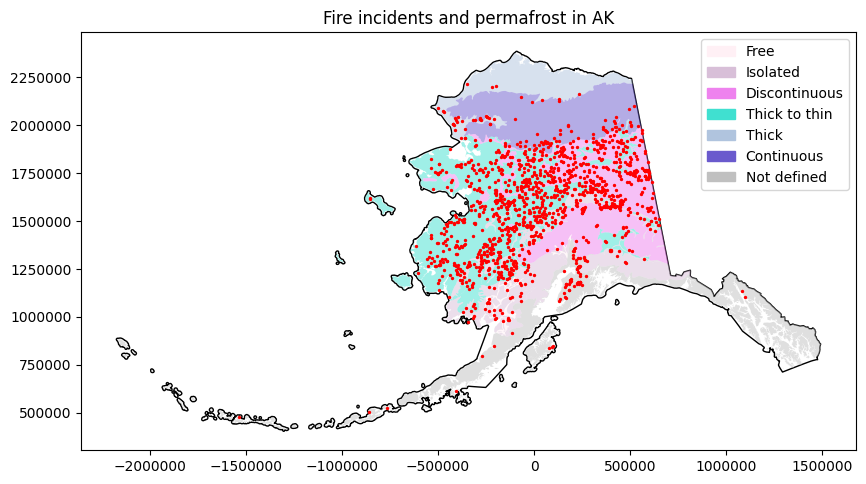

In [355]:
import matplotlib.patches as mpatches
# Mapping permafrost and fire incidents
f, ax = plt.subplots(figsize=(10, 10))

AK_83.plot(ax=ax, color = 'white', edgecolor='black')

# free.plot(ax=ax, facecolor = 'none', edgecolor='lavenderblush', lw=0.5)
# iso.plot(ax=ax, facecolor = 'none', edgecolor='thistle', lw=0.5)
# discon.plot(ax=ax, facecolor = 'none', edgecolor='violet', lw=0.5)
# thick_thin.plot(ax=ax, facecolor = 'none', edgecolor='turquoise', lw=0.5)
# thick.plot(ax=ax, facecolor = 'none', edgecolor='lightsteelblue', lw=0.5)
# con.plot(ax=ax, facecolor = 'none', edgecolor='slateblue', lw=0.5)
# ND.plot(ax=ax, facecolor = 'none', edgecolor='silver', lw=0.5)

free.plot(ax=ax, color='lavenderblush', alpha=.5)
iso.plot(ax=ax, color='thistle', alpha=.5)
discon.plot(ax=ax, color='violet', alpha=.5)
thick_thin.plot(ax=ax, color='turquoise', alpha=.5)
thick.plot(ax=ax, color='lightsteelblue', alpha=.5)
con.plot(ax=ax, color='slateblue', alpha=.5)
ND.plot(ax=ax, color='silver', alpha=.5)

# blackspruce_utm.plot(ax=ax, color = 'darkgreen')
# whitespruce_utm.plot(ax=ax, color = 'springgreen')
# poplar_utm.plot(ax=ax, color = 'tomato')
# aspen_utm.plot(ax=ax, color = 'yellow')
# paperbirch_utm.plot(ax=ax, color = 'darkgoldenrod')

WF_gdf.plot(ax=ax, color = 'red', markersize =2)
#IAK.plot(ax=ax, facecolor = 'none', edgecolor='black', lw=2)



ax.set(title="Fire incidents and permafrost in AK")
plt.ticklabel_format(style='plain')
grey  = mpatches.Patch(color = 'lavenderblush', label = 'Free')
Lblue = mpatches.Patch(color = 'thistle', label = 'Isolated')
Black = mpatches.Patch(color= 'violet', label = 'Discontinuous')
tur  = mpatches.Patch(color = 'turquoise', label = 'Thick to thin')
blue = mpatches.Patch(color = 'lightsteelblue', label = 'Thick')
slate = mpatches.Patch(color= 'slateblue', label = 'Continuous')
silver = mpatches.Patch(color= 'silver', label = 'Not defined')
plt.legend(handles = [grey,Lblue,Black, tur, blue, slate, silver])
#plt.xlim([-162, -140])
#plt.ylim([0, 100])
plt.show()

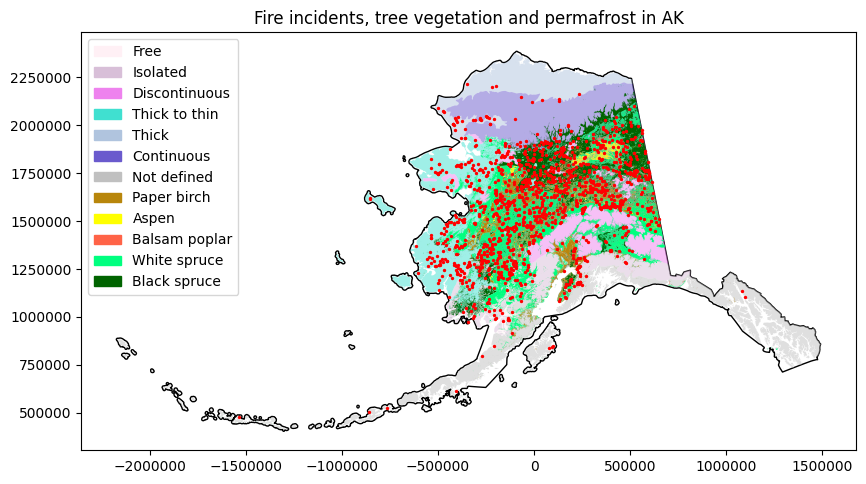

In [354]:
# Mapping everything together
f, ax = plt.subplots(figsize=(10, 10))

AK_83.plot(ax=ax, color = 'white', edgecolor='black')

free.plot(ax=ax, color='lavenderblush', alpha=.5)
iso.plot(ax=ax, color='thistle', alpha=.5)
discon.plot(ax=ax, color='violet', alpha=.5)
thick_thin.plot(ax=ax, color='turquoise', alpha=.5)
thick.plot(ax=ax, color='lightsteelblue', alpha=.5)
con.plot(ax=ax, color='slateblue', alpha=.5)
ND.plot(ax=ax, color='silver', alpha=.5)

blackspruce_utm.plot(ax=ax, color = 'darkgreen')
whitespruce_utm.plot(ax=ax, color = 'springgreen')
poplar_utm.plot(ax=ax, color = 'tomato')
aspen_utm.plot(ax=ax, color = 'yellow')
paperbirch_utm.plot(ax=ax, color = 'darkgoldenrod')

WF_gdf.plot(ax=ax, color = 'red', markersize =2)
#IAK.plot(ax=ax, facecolor = 'none', edgecolor='black', lw=2)

a  = mpatches.Patch(color = 'darkgreen', label = 'Black spruce')
t = mpatches.Patch(color = 'springgreen', label = 'White spruce')
r = mpatches.Patch(color= 'tomato', label = 'Balsam poplar')
d  = mpatches.Patch(color = 'yellow', label = 'Aspen')
white = mpatches.Patch(color = 'darkgoldenrod', label = 'Paper birch')
grey  = mpatches.Patch(color = 'lavenderblush', label = 'Free')
Lblue = mpatches.Patch(color = 'thistle', label = 'Isolated')
Black = mpatches.Patch(color= 'violet', label = 'Discontinuous')
tur  = mpatches.Patch(color = 'turquoise', label = 'Thick to thin')
blue = mpatches.Patch(color = 'lightsteelblue', label = 'Thick')
slate = mpatches.Patch(color= 'slateblue', label = 'Continuous')
silver = mpatches.Patch(color= 'silver', label = 'Not defined')
plt.legend(handles = [grey,Lblue,Black, tur, blue, slate, silver,white,d,r,t,a])

ax.set(title="Fire incidents, tree vegetation and permafrost in AK")
plt.ticklabel_format(style='plain')

plt.show()

## Feature selection


### Removing outliers



#### *Latitude and longitude outliers*


In [388]:
fire_remove = WF_gdf.copy()
fire_remove['lon'] = fire_remove.geometry.apply(lambda p: p.x)
fire_remove['lat'] = fire_remove.geometry.apply(lambda p: p.y)

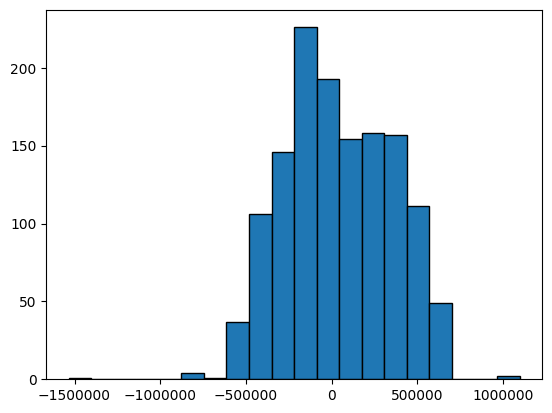

In [389]:
# Plot longitude to see distribution
plt.hist(fire_remove['lon'].dropna(), bins = 20, edgecolor = 'black')
plt.ticklabel_format(style='plain')

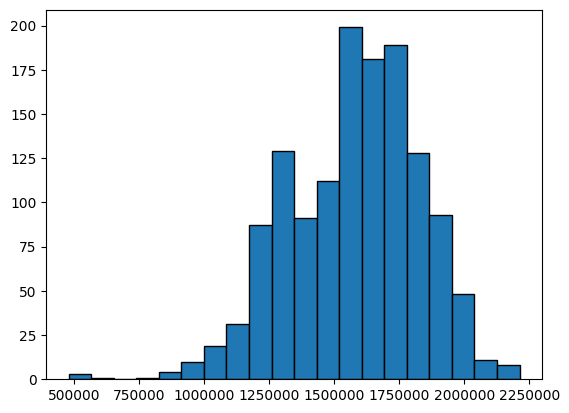

In [390]:
# Plot lat to see distribution
plt.hist(fire_remove['lat'].dropna(), bins = 20, edgecolor = 'black')
plt.ticklabel_format(style='plain')

In [391]:
test = fire_remove.loc[(fire_remove['lat'] > 740000)]

In [381]:
#tester2 = fire_remove.loc[(tester['lon'] < 1000000)]

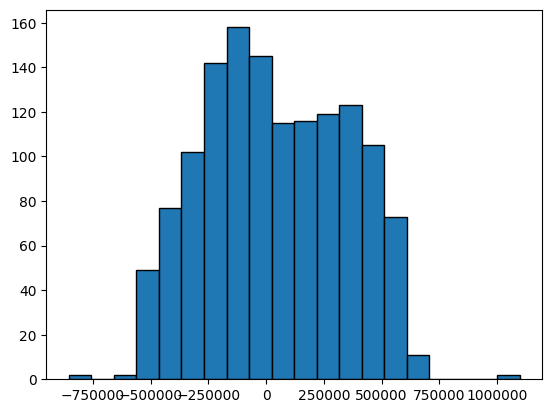

In [392]:
plt.hist(test['lon'].dropna(), bins = 20, edgecolor = 'black')
plt.ticklabel_format(style='plain')

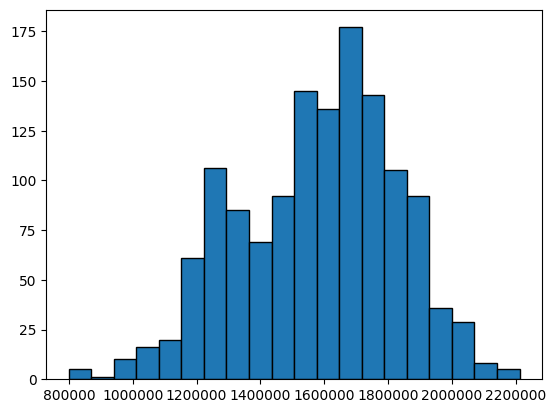

In [393]:
plt.hist(test['lat'].dropna(), bins = 20, edgecolor = 'black')
plt.ticklabel_format(style='plain')

In [394]:
# Compute correlation matrix
corr_matrix = test.corr()

# Display just fire size correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\3333777142.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = test.corr()


IncidentSi                        1.000000
POOCounty_Yukon-Koyukuk           0.164358
FireCause_Undetermined            0.112867
POOLandown_USFWS                  0.088852
POOLandown_Tribal                 0.074429
day                               0.068811
FireCause_Natural                 0.049976
POOCounty_Dillingham              0.029660
year                              0.027521
POOLandown_BLM                    0.026994
POOCounty_Kusilvak                0.026955
POOCounty_Kenai Peninsula         0.013442
lat                               0.011027
POOLandown_State                  0.008551
lon                              -0.007160
POOLandown_DOE                   -0.008552
POOCounty_Bristol Bay            -0.011469
POOLandown_BIA                   -0.012591
POOCounty_Juneau                 -0.013319
POOCounty_Kodiak Island          -0.013727
FireCause_Unknown                -0.018316
POOCounty_Wade Hampton           -0.022583
POOCounty_Lake and Peninsula     -0.023489
distance_to

In [446]:
test.shape

(1341, 58)


#### *Month outliers*


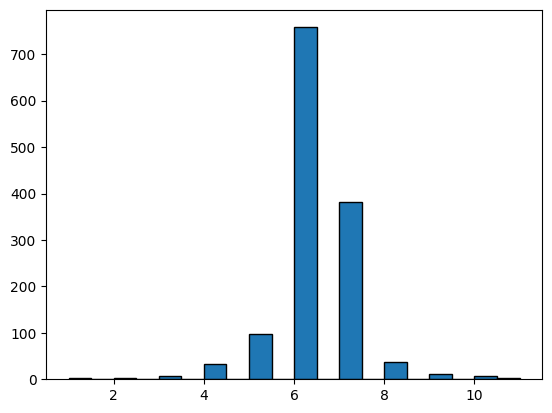

In [395]:
plt.hist(test['month'].dropna(), bins = 20, edgecolor = 'black')
plt.ticklabel_format(style='plain')

In [428]:
# Calculate first and third quartile
first_quartile = test['month'].describe()['25%']
third_quartile = test['month'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
fire_month = test[(test['month'] > (first_quartile - 3 * iqr)) &
            (test['month'] < (third_quartile + 3 * iqr))]

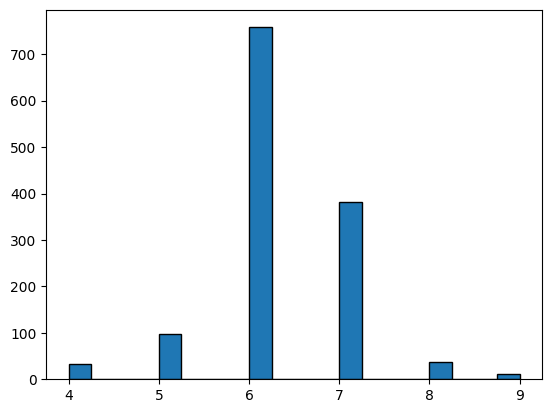

In [397]:
plt.hist(fire_month['month'].dropna(), bins = 20, edgecolor = 'black')
plt.ticklabel_format(style='plain')

In [398]:
# Compute correlation matrix
corr_matrix = fire_month.corr()

# Display just fire size correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\1011882190.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = fire_month.corr()


IncidentSi                        1.000000
POOCounty_Yukon-Koyukuk           0.160588
FireCause_Undetermined            0.140751
POOLandown_USFWS                  0.086549
POOLandown_Tribal                 0.073600
day                               0.068315
FireCause_Natural                 0.040017
POOCounty_Kenai Peninsula         0.028836
POOCounty_Dillingham              0.028792
year                              0.027153
POOCounty_Kusilvak                0.026236
POOLandown_BLM                    0.024544
lat                               0.008492
POOLandown_State                  0.004595
lon                              -0.002837
POOLandown_DOE                   -0.008708
POOCounty_Bristol Bay            -0.011737
POOLandown_BIA                   -0.012997
POOCounty_Juneau                 -0.013542
POOCounty_Kodiak Island          -0.013998
FireCause_Unknown                -0.014753
distance_to_thick                -0.020516
POOLandown_County                -0.022821
POOCounty_W

In [447]:
fire_month.shape

(1320, 58)


#### *County outliers*


In [402]:
# This is the dataframe from before county column was converted
WF_df_time['POOCounty'].value_counts()

Yukon-Koyukuk           617
Bethel                  155
Southeast Fairbanks     130
Northwest Arctic         77
Fairbanks North Star     72
Nome                     49
Denali                   44
Dillingham               36
Kenai Peninsula          29
Matanuska-Susitna        26
Kusilvak                 25
Valdez-Cordova           19
Lake and Peninsula       16
Wade Hampton             14
North Slope              13
Anchorage                11
Bristol Bay               3
Kodiak Island             3
Aleutians West            2
Aleutians East            2
Juneau                    2
Name: POOCounty, dtype: int64

Bristol bay
Kodiak Island
Aleutians West
Aleutians East
Juneau

In [470]:
fire_counties = fire_month.copy()
indexNames = fire_counties[(fire_counties['POOCounty_Juneau'] == 1) |
                              (fire_counties['POOCounty_Bristol Bay'] == 1) | 
                              (fire_counties['POOCounty_Kodiak Island'] == 1) |
                              (fire_counties['POOCounty_Aleutians East'] == 1) |
                              (fire_counties['POOCounty_Aleutians West'] == 1)].index

In [437]:
fire_counties.drop(indexNames , inplace=True)

In [475]:
fire_counties.shape

(1320, 53)

In [472]:
fire_counties = fire_counties.drop(['POOCounty_Juneau', 'POOCounty_Bristol Bay', 
                    'POOCounty_Kodiak Island', 'POOCounty_Aleutians East', 
                    'POOCounty_Aleutians West'], axis=1)

In [476]:
# Compute correlation matrix
corr_matrix = fire_counties.corr()

# Display just fire size correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\2152956899.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = fire_counties.corr()


IncidentSi                        1.000000
POOCounty_Yukon-Koyukuk           0.160588
FireCause_Undetermined            0.140751
POOLandown_USFWS                  0.086549
POOLandown_Tribal                 0.073600
day                               0.068315
FireCause_Natural                 0.040017
POOCounty_Kenai Peninsula         0.028836
POOCounty_Dillingham              0.028792
year                              0.027153
POOCounty_Kusilvak                0.026236
POOLandown_BLM                    0.024544
lat                               0.008492
POOLandown_State                  0.004595
lon                              -0.002837
POOLandown_DOE                   -0.008708
POOLandown_BIA                   -0.012997
FireCause_Unknown                -0.014753
distance_to_thick                -0.020516
POOLandown_County                -0.022821
POOCounty_Wade Hampton           -0.023164
POOCounty_Lake and Peninsula     -0.024110
POOLandown_USFS                  -0.026888
POOCounty_B

In [469]:
WF_df_time['POOLandown'].value_counts()

State      469
USFWS      240
BLM        237
ANCSA      160
NPS         83
DOD         72
Tribal      37
Private     17
USFS        14
County       8
BIA          7
DOE          1
Name: POOLandown, dtype: int64

In [477]:
fire_owner = fire_counties.drop(['POOLandown_DOE', 'POOLandown_BIA', 
                    'POOLandown_County'], axis=1)

In [565]:
# Compute correlation matrix
corr_matrix = fire_owner.corr()

# Display just fire size correlations
corr_matrix["IncidentSi"].sort_values(ascending= False)

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\2186543477.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = fire_owner.corr()


IncidentSi                        1.000000
POOCounty_Yukon-Koyukuk           0.160588
FireCause_Undetermined            0.140751
POOLandown_USFWS                  0.086549
POOLandown_Tribal                 0.073600
day                               0.068315
FireCause_Natural                 0.040017
POOCounty_Kenai Peninsula         0.028836
POOCounty_Dillingham              0.028792
year                              0.027153
POOCounty_Kusilvak                0.026236
POOLandown_BLM                    0.024544
lat                               0.008492
POOLandown_State                  0.004595
lon                              -0.002837
FireCause_Unknown                -0.014753
distance_to_thick                -0.020516
POOCounty_Wade Hampton           -0.023164
POOCounty_Lake and Peninsula     -0.024110
POOLandown_USFS                  -0.026888
POOCounty_Bethel                 -0.028170
POOCounty_North Slope            -0.029578
POOCounty_Anchorage              -0.029740
POOCounty_N

In [656]:
fire_owner.shape

(1320, 50)

In [648]:
fire_owner.to_file('data/fire_owner')

C:\Users\16147\AppData\Local\Temp\ipykernel_11592\4152481914.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fire_owner.to_file('data/fire_owner')


## Run 1: with everything 

### Feature scale

In [649]:
# Creating copy
big_df = fire_owner.copy()

feature_list =  ['year', 'month', 'day', 'FireCause_Human', 'FireCause_Natural',
       'FireCause_Undetermined', 'FireCause_Unknown', 'POOCounty_Anchorage',
       'POOCounty_Bethel', 'POOCounty_Denali', 'POOCounty_Dillingham',
       'POOCounty_Fairbanks North Star', 'POOCounty_Kenai Peninsula',
       'POOCounty_Kusilvak', 'POOCounty_Lake and Peninsula',
       'POOCounty_Matanuska-Susitna', 'POOCounty_Nome',
       'POOCounty_North Slope', 'POOCounty_Northwest Arctic',
       'POOCounty_Southeast Fairbanks', 'POOCounty_Valdez-Cordova',
       'POOCounty_Wade Hampton', 'POOCounty_Yukon-Koyukuk', 'POOLandown_ANCSA',
       'POOLandown_BLM', 'POOLandown_DOD', 'POOLandown_NPS',
       'POOLandown_Private', 'POOLandown_State', 'POOLandown_Tribal',
       'POOLandown_USFS', 'POOLandown_USFWS', 'distance_to_blackspruce',
       'distance_to_paperbirch', 'distance_to_whitespruce',
       'distance_to_aspen', 'distance_to_poplar', 'distance_to_free',
       'distance_to_discon', 'distance_to_iso', 'distance_to_thick_thin',
       'distance_to_thick', 'distance_to_con', 'distance_to_ND', 'lat', 'lon']

# Define features and labels 
#X = big_df.drop(['IncidentSi', 'OBJECTID', 'lat', 'lon', 'geometry'], axis = 1) #first run
X = big_df[feature_list]
Y = big_df['IncidentSi']

In [652]:
X = X.astype(float)
#print(X.dtypes)

In [655]:
X.shape

(1320, 46)

In [657]:
# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feature_list)
df_scaled

,year,month,day,FireCause_Human,FireCause_Natural,FireCause_Undetermined,FireCause_Unknown,POOCounty_Anchorage,POOCounty_Bethel,POOCounty_Denali,...,distance_to_poplar,distance_to_free,distance_to_discon,distance_to_iso,distance_to_thick_thin,distance_to_thick,distance_to_con,distance_to_ND,lat,lon
0,1.588340,-0.321913,1.278690,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.637993,-0.484342,-0.285153,-0.798650,-0.446372,-0.139618,-0.540523,-0.547614,0.295237,0.311835
1,1.588340,-0.321913,1.522179,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.610982,-0.186308,-0.442619,-0.089587,-0.446372,-0.384704,-0.351049,-0.191917,0.141086,-0.270152
2,-0.725798,3.564596,-0.425738,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.568764,-0.907204,0.793836,-0.362435,3.272881,2.094464,1.642607,-1.940540,-1.688657,0.693805
3,0.045581,3.564596,1.400434,2.914859,-2.566361,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.500926,-0.333490,-0.594444,-0.844966,-0.318497,0.017260,-0.332302,-0.418471,0.348751,0.859567
4,1.588340,0.973590,-1.034462,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.408321,-0.748719,0.071215,-0.844966,-0.321880,0.081759,-0.115391,-0.827944,-0.127231,0.049395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.045581,-0.321913,-1.156207,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.481136,0.194472,-0.636071,-0.167281,-0.232035,-0.649335,-1.076690,0.125384,0.778922,0.206209
1316,-1.497177,2.269093,-0.425738,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,0.553783,0.868687,-0.436338,0.283915,-0.446372,-0.901617,-0.314299,0.992484,0.296610,-1.039859
1317,-1.111487,-0.321913,1.278690,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.375003,-0.843691,-0.391210,-0.844966,-0.424552,0.171591,0.082269,-0.781350,-0.291096,-0.089106
1318,-1.111487,-0.321913,0.791710,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.630379,-0.082587,-0.451150,-0.176845,-0.446372,-0.451973,-0.356681,-0.068997,0.169470,-0.347636


### Model building

In [658]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [659]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

### Evaulate model

In [660]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

26812.876776541987

In [661]:
#Checking the accuracy
random_model_accuracy = round(forest_reg.score(X_train, y_train)*100,2)
print(round(random_model_accuracy, 2), '%')

86.36 %


In [662]:
random_model_accuracy1 = round(forest_reg.score(X_test, y_test)*100,2)
print(round(random_model_accuracy1, 2), '%')

12.68 %



## Run 2: removing features, vegetation and permafrost focus


In [663]:
# Creating copy
big_df_vegperm = fire_owner.copy()

feature_list =  ['year', 'month', 'day', 'FireCause_Human', 'FireCause_Natural',
       'POOCounty_Bethel', 'POOCounty_Denali', 'POOCounty_Dillingham',
       'POOCounty_Fairbanks North Star', 'POOCounty_Kenai Peninsula',
       'POOCounty_Kusilvak',
       'POOCounty_Matanuska-Susitna', 'POOCounty_Nome',
       'POOCounty_Northwest Arctic',
       'POOCounty_Southeast Fairbanks',
       'POOCounty_Wade Hampton', 'POOCounty_Yukon-Koyukuk', 'POOLandown_ANCSA',
       'POOLandown_BLM', 'POOLandown_DOD', 'POOLandown_NPS',
       'POOLandown_Private', 'POOLandown_State', 'POOLandown_Tribal',
       'POOLandown_USFWS', 'distance_to_blackspruce',
       'distance_to_paperbirch', 'distance_to_whitespruce',
       'distance_to_aspen', 'distance_to_poplar', 'distance_to_free',
       'distance_to_discon', 'distance_to_iso', 'distance_to_thick_thin',
       'distance_to_thick', 'distance_to_con', 'distance_to_ND', 'lat', 'lon']

# Define features and labels 
X = big_df_vegperm[feature_list]
Y = big_df_vegperm['IncidentSi']

In [664]:
X = X.astype(float)
#print(X.dtypes)

In [665]:
# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feature_list)
df_scaled

,year,month,day,FireCause_Human,FireCause_Natural,POOCounty_Bethel,POOCounty_Denali,POOCounty_Dillingham,POOCounty_Fairbanks North Star,POOCounty_Kenai Peninsula,...,distance_to_poplar,distance_to_free,distance_to_discon,distance_to_iso,distance_to_thick_thin,distance_to_thick,distance_to_con,distance_to_ND,lat,lon
0,1.588340,-0.321913,1.278690,-0.343070,-2.566361,-0.364756,-0.183501,-0.167444,-0.233052,-0.130189,...,-0.637993,-0.484342,-0.285153,-0.798650,-0.446372,-0.139618,-0.540523,-0.547614,0.295237,0.311835
1,1.588340,-0.321913,1.522179,-0.343070,-2.566361,-0.364756,-0.183501,-0.167444,-0.233052,-0.130189,...,-0.610982,-0.186308,-0.442619,-0.089587,-0.446372,-0.384704,-0.351049,-0.191917,0.141086,-0.270152
2,-0.725798,3.564596,-0.425738,-0.343070,-2.566361,-0.364756,-0.183501,-0.167444,-0.233052,7.681146,...,-0.568764,-0.907204,0.793836,-0.362435,3.272881,2.094464,1.642607,-1.940540,-1.688657,0.693805
3,0.045581,3.564596,1.400434,2.914859,-2.566361,-0.364756,-0.183501,-0.167444,4.290893,-0.130189,...,-0.500926,-0.333490,-0.594444,-0.844966,-0.318497,0.017260,-0.332302,-0.418471,0.348751,0.859567
4,1.588340,0.973590,-1.034462,-0.343070,-2.566361,-0.364756,-0.183501,-0.167444,-0.233052,-0.130189,...,-0.408321,-0.748719,0.071215,-0.844966,-0.321880,0.081759,-0.115391,-0.827944,-0.127231,0.049395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.045581,-0.321913,-1.156207,-0.343070,0.389657,-0.364756,-0.183501,-0.167444,-0.233052,-0.130189,...,-0.481136,0.194472,-0.636071,-0.167281,-0.232035,-0.649335,-1.076690,0.125384,0.778922,0.206209
1316,-1.497177,2.269093,-0.425738,-0.343070,0.389657,-0.364756,-0.183501,-0.167444,-0.233052,-0.130189,...,0.553783,0.868687,-0.436338,0.283915,-0.446372,-0.901617,-0.314299,0.992484,0.296610,-1.039859
1317,-1.111487,-0.321913,1.278690,-0.343070,0.389657,-0.364756,-0.183501,-0.167444,-0.233052,-0.130189,...,-0.375003,-0.843691,-0.391210,-0.844966,-0.424552,0.171591,0.082269,-0.781350,-0.291096,-0.089106
1318,-1.111487,-0.321913,0.791710,-0.343070,0.389657,-0.364756,-0.183501,-0.167444,-0.233052,-0.130189,...,-0.630379,-0.082587,-0.451150,-0.176845,-0.446372,-0.451973,-0.356681,-0.068997,0.169470,-0.347636


In [666]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [671]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

In [672]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

28291.516215771528

In [673]:
#Checking the accuracy
random_model_accuracy = round(forest_reg.score(X_train, y_train)*100,2)
print(round(random_model_accuracy, 2), '%')

85.19 %


In [675]:
random_model_accuracy1 = round(forest_reg.score(X_test, y_test)*100,2)
print(round(random_model_accuracy1, 2), '%')

2.79 %



## Run 3: vegetation focused


In [676]:
# Creating copy
veg_df = fire_owner.copy()

feature_list =  ['year', 'month', 'day', 'FireCause_Human', 'FireCause_Natural',
       'FireCause_Undetermined', 'FireCause_Unknown', 'POOCounty_Anchorage',
       'POOCounty_Bethel', 'POOCounty_Denali', 'POOCounty_Dillingham',
       'POOCounty_Fairbanks North Star', 'POOCounty_Kenai Peninsula',
       'POOCounty_Kusilvak', 'POOCounty_Lake and Peninsula',
       'POOCounty_Matanuska-Susitna', 'POOCounty_Nome',
       'POOCounty_North Slope', 'POOCounty_Northwest Arctic',
       'POOCounty_Southeast Fairbanks', 'POOCounty_Valdez-Cordova',
       'POOCounty_Wade Hampton', 'POOCounty_Yukon-Koyukuk', 'POOLandown_ANCSA',
       'POOLandown_BLM', 'POOLandown_DOD', 'POOLandown_NPS',
       'POOLandown_Private', 'POOLandown_State', 'POOLandown_Tribal',
       'POOLandown_USFS', 'POOLandown_USFWS', 'distance_to_blackspruce',
       'distance_to_paperbirch', 'distance_to_whitespruce',
       'distance_to_aspen', 'distance_to_poplar', 'lat', 'lon']

# Define features and labels 
X = veg_df[feature_list]
Y = veg_df['IncidentSi']

In [677]:
X = X.astype(float)
#print(X.dtypes)

In [678]:
# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feature_list)
df_scaled

,year,month,day,FireCause_Human,FireCause_Natural,FireCause_Undetermined,FireCause_Unknown,POOCounty_Anchorage,POOCounty_Bethel,POOCounty_Denali,...,POOLandown_Tribal,POOLandown_USFS,POOLandown_USFWS,distance_to_blackspruce,distance_to_paperbirch,distance_to_whitespruce,distance_to_aspen,distance_to_poplar,lat,lon
0,1.588340,-0.321913,1.278690,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.169819,-0.078087,-0.471405,-0.346358,-0.440340,-0.278915,-0.603589,-0.637993,0.295237,0.311835
1,1.588340,-0.321913,1.522179,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.169819,-0.078087,2.121320,-0.369670,-0.434015,-0.277392,-0.579466,-0.610982,0.141086,-0.270152
2,-0.725798,3.564596,-0.425738,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.169819,12.806248,-0.471405,-0.256489,-0.436985,-0.284501,-0.419622,-0.568764,-1.688657,0.693805
3,0.045581,3.564596,1.400434,2.914859,-2.566361,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.169819,-0.078087,-0.471405,-0.353803,-0.432460,-0.286569,-0.590984,-0.500926,0.348751,0.859567
4,1.588340,0.973590,-1.034462,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.169819,-0.078087,-0.471405,-0.369670,-0.408298,-0.285450,-0.361857,-0.408321,-0.127231,0.049395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.045581,-0.321913,-1.156207,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.169819,-0.078087,-0.471405,-0.345378,-0.440961,0.091698,-0.577463,-0.481136,0.778922,0.206209
1316,-1.497177,2.269093,-0.425738,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,5.888606,-0.078087,-0.471405,0.574178,0.187462,-0.229202,0.362989,0.553783,0.296610,-1.039859
1317,-1.111487,-0.321913,1.278690,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.169819,-0.078087,-0.471405,-0.319648,-0.435790,-0.286569,-0.525651,-0.375003,-0.291096,-0.089106
1318,-1.111487,-0.321913,0.791710,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,5.888606,-0.078087,-0.471405,-0.354327,-0.441883,-0.279034,-0.587493,-0.630379,0.169470,-0.347636


In [679]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [680]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

In [681]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

28527.022701844966

In [682]:
#Checking the accuracy
random_model_accuracy = round(forest_reg.score(X_train, y_train)*100,2)
print(round(random_model_accuracy, 2), '%')

87.63 %


In [683]:
random_model_accuracy1 = round(forest_reg.score(X_test, y_test)*100,2)
print(round(random_model_accuracy1, 2), '%')

1.16 %



## Run 4: permafrost focused


In [684]:
# Creating copy
perm_df = fire_owner.copy()

feature_list =  ['year', 'month', 'day', 'FireCause_Human', 'FireCause_Natural',
       'FireCause_Undetermined', 'FireCause_Unknown', 'POOCounty_Anchorage',
       'POOCounty_Bethel', 'POOCounty_Denali', 'POOCounty_Dillingham',
       'POOCounty_Fairbanks North Star', 'POOCounty_Kenai Peninsula',
       'POOCounty_Kusilvak', 'POOCounty_Lake and Peninsula',
       'POOCounty_Matanuska-Susitna', 'POOCounty_Nome',
       'POOCounty_North Slope', 'POOCounty_Northwest Arctic',
       'POOCounty_Southeast Fairbanks', 'POOCounty_Valdez-Cordova',
       'POOCounty_Wade Hampton', 'POOCounty_Yukon-Koyukuk', 'POOLandown_ANCSA',
       'POOLandown_BLM', 'POOLandown_DOD', 'POOLandown_NPS',
       'POOLandown_Private', 'POOLandown_State', 'POOLandown_Tribal',
       'POOLandown_USFS', 'POOLandown_USFWS', 'distance_to_free',
       'distance_to_discon', 'distance_to_iso', 'distance_to_thick_thin',
       'distance_to_thick', 'distance_to_con', 'distance_to_ND', 'lat', 'lon']

# Define features and labels 
X = perm_df[feature_list]
Y = perm_df['IncidentSi']

In [685]:
X = X.astype(float)
#print(X.dtypes)

In [686]:
# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feature_list)
df_scaled

,year,month,day,FireCause_Human,FireCause_Natural,FireCause_Undetermined,FireCause_Unknown,POOCounty_Anchorage,POOCounty_Bethel,POOCounty_Denali,...,POOLandown_USFWS,distance_to_free,distance_to_discon,distance_to_iso,distance_to_thick_thin,distance_to_thick,distance_to_con,distance_to_ND,lat,lon
0,1.588340,-0.321913,1.278690,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,-0.484342,-0.285153,-0.798650,-0.446372,-0.139618,-0.540523,-0.547614,0.295237,0.311835
1,1.588340,-0.321913,1.522179,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,2.121320,-0.186308,-0.442619,-0.089587,-0.446372,-0.384704,-0.351049,-0.191917,0.141086,-0.270152
2,-0.725798,3.564596,-0.425738,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,-0.907204,0.793836,-0.362435,3.272881,2.094464,1.642607,-1.940540,-1.688657,0.693805
3,0.045581,3.564596,1.400434,2.914859,-2.566361,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,-0.333490,-0.594444,-0.844966,-0.318497,0.017260,-0.332302,-0.418471,0.348751,0.859567
4,1.588340,0.973590,-1.034462,-0.343070,-2.566361,7.348469,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,-0.748719,0.071215,-0.844966,-0.321880,0.081759,-0.115391,-0.827944,-0.127231,0.049395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.045581,-0.321913,-1.156207,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,0.194472,-0.636071,-0.167281,-0.232035,-0.649335,-1.076690,0.125384,0.778922,0.206209
1316,-1.497177,2.269093,-0.425738,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,0.868687,-0.436338,0.283915,-0.446372,-0.901617,-0.314299,0.992484,0.296610,-1.039859
1317,-1.111487,-0.321913,1.278690,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,-0.843691,-0.391210,-0.844966,-0.424552,0.171591,0.082269,-0.781350,-0.291096,-0.089106
1318,-1.111487,-0.321913,0.791710,-0.343070,0.389657,-0.136083,-0.09167,-0.09167,-0.364756,-0.183501,...,-0.471405,-0.082587,-0.451150,-0.176845,-0.446372,-0.451973,-0.356681,-0.068997,0.169470,-0.347636


In [687]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [688]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

In [689]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

27129.290149292723

In [690]:
#Checking the accuracy
random_model_accuracy = round(forest_reg.score(X_train, y_train)*100,2)
print(round(random_model_accuracy, 2), '%')

87.23 %


In [691]:
random_model_accuracy1 = round(forest_reg.score(X_test, y_test)*100,2)
print(round(random_model_accuracy1, 2), '%')

10.61 %
